<a href="https://colab.research.google.com/github/marie-ganon/Projet-Python-S1/blob/main/Scraping_nettoyage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chargement des packages utiles

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from urllib import request
from wordcloud import WordCloud, STOPWORDS 
import csv
import bs4
from tqdm.notebook import trange, tqdm
import seaborn as sns
import numpy as np

## Aperçu de la base initiale

La base que nous avons décidé de choisir pour mener à bien notre projet est un ensemble de données collecté par TMDB (The Movie Database, une API), ainsi que GroupLens, un laboratoire de recherche de l'université du Minnesota.

Le dataset est disponible à l'adresse suivante : https://www.kaggle.com/rounakbanik/the-movies-dataset.

Ces données regroupent plus de 45 000 films et donnent de nombreuses caractéristiques, tels que le genre, le budget et le revenu généré par le film. Une partie de la base a été prénettoyée sur Excel et avec des méthodes Python simples. 

In [2]:
# On crée un dossier temporaire pour dézipper le csv
import tempfile

temp_dir = tempfile.mkdtemp()


In [399]:
# Pour dezipper le csv disponible dans le git (movies metadata)

import zipfile

with zipfile.ZipFile('/movies_metadata.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('temp_dir')
    

In [400]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
df = pd.read_csv(r'temp_dir/movies_metadata.csv', sep=',', low_memory = False)

# Nettoyage sur la base

On regarde : 
- quelles colonnes sont les mieux renseignées
- quelles colonnes il faut supprimer
- si les types de chaque variable est cohérent

#### Sommaire 
1. Nettoyage des colonnes
2. Nettoyage sur les lignes
3. Nettoyage variable par variable
    - *popularity*
    - *vote_average* et *vote_count*
    - *production_companies* et *production_countries*

## Nettoyage des colonnes

Complétude totale en pourcentage de la base : 90.32592120119062 %


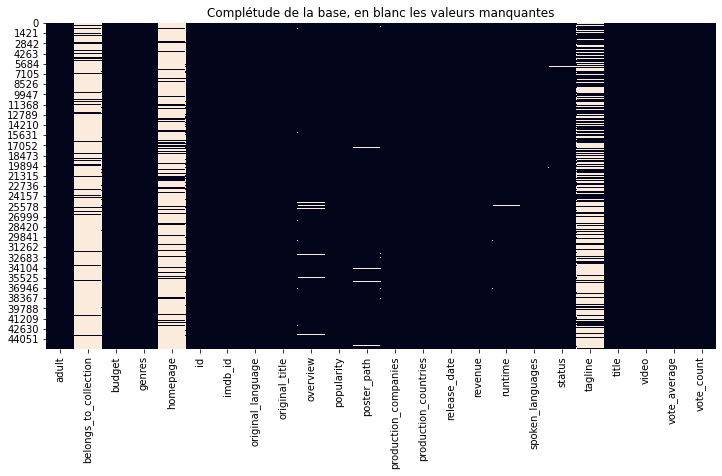

In [76]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Complétude de la base, en blanc les valeurs manquantes')
print("Complétude totale en pourcentage de la base :", (1-df.isnull().sum().sum()/(len(df.id)*len(df.columns)))*100,'%')

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

En explorant les premières colonnes de la base et le site The Movie DataBase, on comprend mieux le sens des colonnes :

- *adult* : Booléen qui indique si oui ou non le film est un film pour adultes
- *belongs_to_collection*
- *budget* : budget de production du film
- *genres* : Genre cinématographique du film
- *homepage* : Lien menant à la page d'accueil du film si elle existe
- *id* : Identifiant du film sur le site The Movie DataBase
- *imdb_id* : Identifiant du film sur le site Internet Movie DataBase
- *original_language* : Langue dans laquelle le film a été tourné
-	*original_title* : Titre originel du film
- *overview* : Synopsis du film
-	*popularity* : Indicateur de la popularité du film
- *poster_path* : Chemin d'accès à l'affiche du film présentée sur la version anglophone de TMDB (si elle existe)
- *production_companies* : Compagnie qui a produit le film
-	*production_countries* : Pays dans lequel le film a été produit
- *release_date* : Date de première sortie du film, donnée sur TMDB
- *revenue*	: Revenus générés par le film selon TMDB
- *runtime*	: Durée du film
- *spoken_languages* : Langues parlées dans la versionn originale du film
- *status* : Indique si le film est sorti ou non
- *tagline* : slogan/phrase d'accroche du film sur la page anglophone de TMDB (si elle existe)
-	*title*	: Titre du film en anglais
- *video*	: Booléen
- *vote_average* : Moyenne des votes (à l'époque où la base a été constituée) sur TMDB
-	*vote_count* : Nombre de votes (à l'époque où la base a été constituée) sur TMDB


Notre base de données est très volumineuse. Or toutes les colonnes ne nous seront pas utiles pour notre analyse. Par conséquent, pour une question de mémoire nous avons décidé de les supprimer. 

En particulier, les informations données dans la colonne *spoken_languages* étant peu claires, nous préférons enlever cette colonne de notre dataset.
Les informations *taglines*, *homepage* et *belongs_to_collection* ne sont pas très bien renseignées ni forcément pertinentes, on va donc les dropper de même. En revanche, avant de dropper *belongs_to_collection*, on va créer une variable binaire renseignant si oui ou non un film appartient à une collection (c'est-à-dire correspond à un volet de plusieurs films) puisqu'il s'agit d'une information pouvant avoir une importance significative sur le succès du film. 

Tous les types sont des *object* à l'exception des variables *revenue*, *runtime*, *vote_average*, et *vote_count*. On s'attend toutefois à avoir pour *popularity* qui est un score de popularité ainsi que pour *budget* des formats *float64* ou *int*. Il faudra se pencher sur ces variables. 

In [78]:
df.belongs_to_collection

0        {'id': 10194, 'name': 'Toy Story Collection', ...
1                                                      NaN
2        {'id': 119050, 'name': 'Grumpy Old Men Collect...
3                                                      NaN
4        {'id': 96871, 'name': 'Father of the Bride Col...
                               ...                        
45461                                                  NaN
45462                                                  NaN
45463                                                  NaN
45464                                                  NaN
45465                                                  NaN
Name: belongs_to_collection, Length: 45466, dtype: object

In [79]:
df.belongs_to_collection = df.belongs_to_collection.fillna(0)

*collection* prend la valeur 1 si le film appartient à une collection, 0 sinon. 

In [80]:
df['collection']= np.where(df['belongs_to_collection']!= 0, 1, 0)

In [81]:
df.collection.head()

0    1
1    0
2    1
3    0
4    1
Name: collection, dtype: int64

In [82]:
df = df.drop(columns ='spoken_languages')
df = df.drop(columns ='tagline')
df = df.drop(columns ='homepage')
df = df.drop(columns ='belongs_to_collection')

In [83]:
df.columns

Index(['adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'status', 'title', 'video', 'vote_average',
       'vote_count', 'collection'],
      dtype='object')

On va s'intéresser rapidement aux types de chaque variable et en tirer leur pertinence ou non pour notre étude. 

In [84]:
pd.unique(df.adult)

array(['False', 'True', ' - Written by Ørnås',
       ' Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.',
       ' Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.'],
      dtype=object)

Vraisemblablement, *adult* est une variable binaire prenant la valeur *True* lorsqu'un film est un film pour adulte, *False* lorsque c'est un film tout public. On remarque qu'il y a des erreurs de collecte lors du scrapping mais cette variable n'étant pas très intéressante pour nous, nous allons la dropper. 

In [85]:
df.head(1)

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,status,title,video,vote_average,vote_count,collection
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,Released,Toy Story,False,7.7,5415.0,1


In [86]:
print('Modalités status :', pd.unique(df.status))
print('Modalités video :', pd.unique(df.video))

Modalités status : ['Released' nan 'Rumored' 'Post Production' 'In Production' 'Planned'
 'Canceled']
Modalités video : [False True nan]


On n'utilisera pas les images à priori. On peut enlever *poster_path*. Les modalités de *video* ne sont pas très intéressantes non plus. 

In [87]:
df = df.drop(columns ='video')
df = df.drop(columns ='poster_path')
df = df.drop(columns ='adult')

## Nettoyage sur les lignes

Nous n'avons pas vérifié encore la cohérence sur les lignes du dataset. Vérifions d'abord que le dataset ne contient que des *id* uniques. Sinon, on retire les informations en surplus. 

In [88]:
print("Doublons d'id : " , len(df)-len(pd.unique(df.id)))
print("Doublons d'id imdb : " , len(df)-len(pd.unique(df.imdb_id)))
df = df.drop_duplicates(subset=['id'])
df = df.drop_duplicates(subset=['imdb_id'])

Doublons d'id :  30
Doublons d'id imdb :  48


D'autre part, on peut enlever tous les 'id' ne correspondant pas à des valeurs convertibles en entier. 

In [89]:
df = df[df.id != '1997-08-20']
df.id.astype('float')

0           862.0
1          8844.0
2         15602.0
3         31357.0
4         11862.0
           ...   
45461    439050.0
45462    111109.0
45463     67758.0
45464    227506.0
45465    461257.0
Name: id, Length: 45417, dtype: float64

## Nettoyage par variable

### *Popularity*
Sur *The Movie Database* un indicateur de popularité a été construit à la date *t* en prenant en compte les informations suivantes d'après la documentation :
- Nombre de votes
- Nombre de vues 
- Nombre de favoris 
- Nombre de gens ayant le film dans leur "watchlist"
- Date de sortie
- Nombre de votes totaux
- Score des jours précédents

Néanmoins, les détails de la métrique ne sont pas explicités. 

In [90]:
df.popularity = df.popularity.astype('float64')
df.popularity.describe()

count    45414.000000
mean         2.921932
std          6.007588
min          0.000000
25%          0.386107
50%          1.127685
75%          3.679143
max        547.488298
Name: popularity, dtype: float64

In [91]:
df.popularity.describe()

count    45414.000000
mean         2.921932
std          6.007588
min          0.000000
25%          0.386107
50%          1.127685
75%          3.679143
max        547.488298
Name: popularity, dtype: float64

Observons les 20 meilleurs films par popularité : 

In [92]:
df.sort_values(by='popularity', ascending=False)['original_title'].head(20)

30700                                             Minions
33356                                        Wonder Woman
42222                                Beauty and the Beast
43644                                         Baby Driver
24455                                          Big Hero 6
26564                                            Deadpool
26566                      Guardians of the Galaxy Vol. 2
14551                                              Avatar
24351                                           John Wick
23675                                           Gone Girl
24873               The Hunger Games: Mockingjay - Part 1
44274                      War for the Planet of the Apes
26567                          Captain America: Civil War
292                                          Pulp Fiction
26560    Pirates of the Caribbean: Dead Men Tell No Tales
12481                                     The Dark Knight
536                                          Blade Runner
17818         

Cela paraît à peu près cohérent, il s'agit bien de films connus. 

Popularity est complet à  99.99339454389326 %


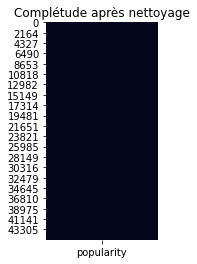

In [93]:
fig, ax = plt.subplots(figsize=(2,4))
sns.heatmap(df[['popularity']].isnull(),cbar=False)
plt.title('Complétude après nettoyage')
print('Popularity est complet à ',(1-len(df.popularity[df.popularity.isnull()])/len(df.popularity))*100,'%')

### *vote_average* et *vote_count*
*vote_average* : variable renseignée sur *TMDb*, elle donne la moyenne des votes sur tMDb sur 10. 

*vote_count* : variable de *TMDb* donnant le nombre de votant pour chaque film. 

In [94]:
print('statistiques: \n ',df.vote_average.describe())

print('nombre de nan: \n', df.vote_average.isnull().sum())

statistiques: 
  count    45414.000000
mean         5.618864
std          1.923210
min          0.000000
25%          5.000000
50%          6.000000
75%          6.800000
max         10.000000
Name: vote_average, dtype: float64
nombre de nan: 
 3


 Notons que le pic à 0 est dû à un certain nombre de films non notés. Il n'y a seulement 4 NaNs, par défaut, le site met une moyenne de votes nuls si le nombre de votant est nul. 

Text(0.5, 1.0, 'Distribution des notes moyennes sur imdb')

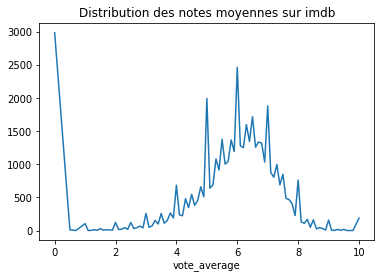

In [95]:
df.groupby(df['vote_average']).imdb_id.count().plot()
plt.title('Distribution des notes moyennes sur imdb')

In [96]:
df.sort_values(by='vote_average', ascending=False)['original_title'].head(20)

44629                                 東京喰種 トーキョーグール
37543    Portrait of a Young Man in Three Movements
30143                            Im Alter von Ellen
394                            Girl in the Cadillac
27404          The Court-Martial of Jackie Robinson
22255                               Cowboy del Amor
39157                                 Truckfighters
44550    Harold and Lillian: A Hollywood Love Story
32797                      אני לא מאמין, אני רובוט!
40269                                       Killjoy
35461                       Tom Brown's School Days
39344                           Survive and Advance
32873                                    Redemption
2114                              The Farmer's Wife
39845                                       Bazodee
37877                              Bowery Battalion
1634                       Other Voices Other Rooms
28152                                Goodbye & Amen
36767                                     Parapalos
32949       

En se basant sur les moyennes des notes seules on observe sans surprise un résultat très différent pour la liste des 20 meilleurs films puisque ces moyennes ne prennent pas en compte le poids du nombre de votes. Dans la liste, il s'agit surtout de films inconnus du grand public. 

In [97]:
print('statistiques: \n',df.vote_count.describe())
print('valeurs manquantes: \n', df.vote_count.isnull().sum())

statistiques: 
 count    45414.000000
mean       109.971837
std        491.549122
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64
valeurs manquantes: 
 3


#### Quelques métriques supplémentaires 
On peut essayer d'établir une métrique permettant d'améliorer l'observation du succès d'un film basé sur sa note.

    score_1 = vote_count × vote_average
    score_2 = vote_count × vote_average²
    score_3 = vote_count² × vote_average


In [98]:
df['score_1'] = df.vote_count.mul(df.vote_average)
df['score_2'] = df.vote_count.mul(df.vote_average.pow(2))
df['score_3'] = df.vote_count.pow(2).mul(df.vote_average)

In [99]:
l_score1 = df.sort_values(by='score_1', ascending=False)['original_title'].head(20).tolist()
l_score2 = df.sort_values(by='score_2', ascending=False)['original_title'].head(20).tolist()
l_score3 = df.sort_values(by='score_3', ascending=False)['original_title'].head(20).tolist()

pd.DataFrame({'score_1': l_score1 ,'score_2' : l_score2, 'score_3' : l_score3})

,score_1,score_2,score_3
0,Inception,Inception,Inception
1,The Dark Knight,The Dark Knight,The Dark Knight
2,Interstellar,Interstellar,The Avengers
3,The Avengers,Fight Club,Avatar
4,Avatar,The Avengers,Interstellar
5,Deadpool,Avatar,Deadpool
6,Fight Club,Deadpool,Django Unchained
7,Django Unchained,Django Unchained,Guardians of the Galaxy
8,Guardians of the Galaxy,Guardians of the Galaxy,Fight Club
9,Pulp Fiction,The Shawshank Redemption,Mad Max: Fury Road


La première métrique obtenue a un résultat correspondant davantage à l'idée que l'on se fait d'un succès critique et commercial d'un film. On observe d'ailleurs que l'on peut jouer sur l'importance de la popularité via le *vote_count* et sur l'importance du succès critique via *vote_average* : le **score_3** met en avant des films "populaires" au sens blockbusters etc. tandis que le **score_2** met en avant des succès critiques tels que Fight Club, ou The Shawshank Redemption. Toutefois cette influence est assez marginale, les scores 1, 2 et 3 sont assez proches, on retiendra donc seulement le **score 1**.

In [100]:
l_pop = df.sort_values(by='popularity', ascending=False)['original_title'].head(20).tolist()
pd.DataFrame({'popularity': l_pop ,'score_1' : l_score1})

,popularity,score_1
0,Minions,Inception
1,Wonder Woman,The Dark Knight
2,Beauty and the Beast,Interstellar
3,Baby Driver,The Avengers
4,Big Hero 6,Avatar
5,Deadpool,Deadpool
6,Guardians of the Galaxy Vol. 2,Fight Club
7,Avatar,Django Unchained
8,John Wick,Guardians of the Galaxy
9,Gone Girl,Pulp Fiction


On pourra retenir *popularity* pour évoquer des film au succès commercial, et *score_1* pour évoquer des films relativement acclamés par la critique et populaires. 

In [101]:
df = df.drop(columns=['score_2', 'score_3'])

### *production companies* et *production countries*

#### *production_companies*

In [102]:
df.production_companies

0           [{'name': 'Pixar Animation Studios', 'id': 3}]
1        [{'name': 'TriStar Pictures', 'id': 559}, {'na...
2        [{'name': 'Warner Bros.', 'id': 6194}, {'name'...
3        [{'name': 'Twentieth Century Fox Film Corporat...
4        [{'name': 'Sandollar Productions', 'id': 5842}...
                               ...                        
45461                                                   []
45462               [{'name': 'Sine Olivia', 'id': 19653}]
45463    [{'name': 'American World Pictures', 'id': 6165}]
45464                 [{'name': 'Yermoliev', 'id': 88753}]
45465                                                   []
Name: production_companies, Length: 45417, dtype: object

Dans la cellule de code suivante, nous allons récupérer les noms des companies de production, ainsi que leur identifiant. Celui-ci s'avérera utile par la suite.

In [103]:
df_temp = df.production_companies.str.split(',')
df_1 = pd.DataFrame()
df_2 = pd.DataFrame()
df_1['name'] = df_temp.str.get(0)
df_1['id'] = df_temp.str.get(1)
df['production_companies_name'] = df_1.name.str.split(':').str.get(1)
df['production_companies_id'] = df_1.id.str.split(':').str.get(1)


On retire ensuite les guillemets qui se trouvent dans les cellules de cette colonne

In [104]:
df.production_companies_name = df.production_companies_name.str.replace(r'[^\w\s]+', '')
df.production_companies_id= df.production_companies_id.str.replace(r'[^\w\s]+', '')
df.production_companies_id = df.production_companies_id.str.replace("'","")
#df.production_companies_id.sort_values(ascending=False).head(100)

On voit des doublons, il faut harmoniser à l'aide des *id* des compagnies de production.
Nous pouvons remarquer quelques effets à corriger : certains films sont mal regroupés en raison de l'utilisation des acronymes ou du nom complet de la société de production. Par exemple, Lionsgate est également présent sous le nom Lions Gate, de même avec la BBC et British Broadcasting Channel etc.


In [105]:
df.production_companies_name.head()

0                    Pixar Animation Studios
1                           TriStar Pictures
2                                Warner Bros
3     Twentieth Century Fox Film Corporation
4                      Sandollar Productions
Name: production_companies_name, dtype: object

In [106]:
df['pc_id_count'] = df.groupby(['production_companies_id'])['production_companies_name'].transform('count')
#df['pc_id_count']=df['production_companies_id'].map(df['production_companies_id'].value_counts())

In [107]:
df[['pc_id_count', 'production_companies_name', 'production_companies_id']].head()

,pc_id_count,production_companies_name,production_companies_id
0,29.0,Pixar Animation Studios,3
1,163.0,TriStar Pictures,559
2,757.0,Warner Bros,6194
3,780.0,Twentieth Century Fox Film Corporation,306
4,5.0,Sandollar Productions,5842


In [444]:
df.production_companies_id = df.production_companies_id.fillna(0)
df.production_companies_id = df.production_companies_id.astype(int)
df.production_companies_name = df.production_companies_name.fillna('Non renseigné')

In [445]:
df.sort_values(by='production_companies_id')[['pc_id_count', 'production_companies_name', 'production_companies_id']].head()

,pc_id_count,production_companies_name,production_companies_id
id,,,
461257,NaN,Non renseigné,0
34505,NaN,Non renseigné,0
20147,NaN,Non renseigné,0
182528,NaN,Non renseigné,0
28652,NaN,Non renseigné,0


On construit un dictionnaire reliant *id* et *noms* des compagnies de production. 

In [446]:
dico_pc = df.groupby('production_companies_id').production_companies_name.agg('min').transpose().to_dict()

In [447]:
print(dico_pc.keys(),dico_pc[1])

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 62, 64, 65, 67, 70, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 94, 97, 98, 99, 100, 101, 103, 104, 105, 107, 109, 110, 112, 113, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 146, 147, 148, 149, 151, 152, 153, 155, 156, 157, 158, 161, 162, 163, 164, 165, 166, 168, 170, 171, 173, 174, 175, 176, 177, 178, 181, 182, 183, 185, 186, 189, 190, 191, 194, 196, 197, 198, 199, 200, 201, 203, 204, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 227, 228, 229, 230, 231, 233, 234, 235, 236, 238, 239, 240, 241, 242, 243, 245, 246, 247, 248, 249, 250, 251, 254, 255, 258, 259, 260, 261, 263, 264, 266, 267, 268, 269, 272, 273, 274, 276, 278, 280, 282

On va pouvoir remplacer les noms des compagnies de production maintenant pour les homogénéiser. 

In [ ]:
for film in trange(len(df.index)):
  num_prod = df.production_companies_id[film]
  df.replace(df.production_companies_name[film], dico_pc[num_prod])

#### *production_countries*

In [108]:
df.production_countries.str.split(',').str.get(1)

0         'name': 'United States of America'}]
1         'name': 'United States of America'}]
2         'name': 'United States of America'}]
3         'name': 'United States of America'}]
4         'name': 'United States of America'}]
                         ...                  
45461                         'name': 'Iran'}]
45462                  'name': 'Philippines'}]
45463     'name': 'United States of America'}]
45464                       'name': 'Russia'}]
45465               'name': 'United Kingdom'}]
Name: production_countries, Length: 45417, dtype: object

In [109]:
df_temp = df.production_countries.str.split(',')
df_1 = pd.DataFrame()
df_2 = pd.DataFrame()
df_1['country_code'] = df_temp.str.get(0)
df_1['country_name'] = df_temp.str.get(1)
df['country_code'] = df_1.country_code.str.split(':').str.get(1)
df_2['country_name_try'] = df_1.country_name.str.split(':').str.get(1)
df['country_name']=df_2['country_name_try'].str.split('}').str.get(0)

df.country_code = df.country_code.str.replace(r'[^\w\s]+', '')
df.country_name = df.country_name.str.replace(r'[^\w\s]+', '')

On supprime les colonnes dédoublées à cause du nettoyage

In [110]:
df = df.drop(columns=['production_companies','production_countries'])

Country_name est complet à  86.1857894620957 %


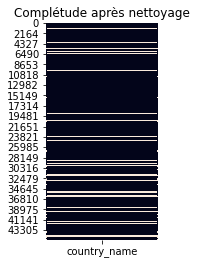

In [111]:
fig, ax = plt.subplots(figsize=(2,4))
sns.heatmap(df[['country_name']].isnull(),cbar=False)
plt.title('Complétude après nettoyage')
print('Country_name est complet à ',(1-len(df.country_name[df.country_name.isnull()])/len(df.country_name))*100,'%')

In [112]:
df.columns

Index(['budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'release_date', 'revenue',
       'runtime', 'status', 'title', 'vote_average', 'vote_count',
       'collection', 'score_1', 'production_companies_name',
       'production_companies_id', 'pc_id_count', 'country_code',
       'country_name'],
      dtype='object')

### *Genre*
Le but de cette partie est de supprimer les caractères non-essentiels qui se trouvent dans les cellules de cette colonne, tels que les id et les name.




In [113]:
df.genres = df.genres.str.replace(r'[^\w\s]+', '')
df.genres[0]

'id 16 name Animation id 35 name Comedy id 10751 name Family'

Dans cet exemple, il nous faut seulement les mots Animation, Comedy et Family. Grâce à la fonction split(), nous pouvons transformer cette chaîne de caractère en liste, puis récupérer les mots qui nous intéressent. Le code suivant réalise cette opération pour toutes les cellules de cette colonne

In [114]:
for i in trange(len(df)):
  genre = df.genres[i].split()
  df.genres[i] = ""
  for j in range(len(genre)//4):
    if j == 0 :
      df.genres[i] = df.genres[i] + genre[3]
    else : 
      df.genres[i] = df.genres[i] + ', ' + genre[3 + j*4]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



KeyError: ignored

In [ ]:
df.groupby(df['genres']).imdb_id.count().sort_values(ascending = False)[:10].plot(kind = 'barh')

Les films de genre drame, comédie et documentaire sont les plus représentés dans l'ensemble des films. Remarquons que les genres n'ont pas été récupérés indépendamment : on considère comme un genre à part entière des subsets composés de plusieurs genres. On pourrait vouloir voir la proportion des films contenant Drama ou Romance par exemple.

In [ ]:
l = []
for i in trange(len(df)):
    genre = df.genres[i].split()
    for i in genre :
        l.append(i)
genre = pd.DataFrame(l, columns=['genre'])
genre = genre.genre.str.replace(r',', '')
genre

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(y = genre)
plt.title('Occurrences totales des genres')

Ces premières statistiques descriptives nous font apparaître que la base n'est pas bien nettoyée puiqu'il reste des id et des entrées qui ne correspondent pas au genre.

In [115]:
df.genres[df.genres == '[]'].sort_values()

Series([], Name: genres, dtype: object)

In [116]:
df = df[df.genres != '[]']
df = df[df.genres != '']
df.genres[df.genres.notnull()].sort_values()

1130                                                Action
690                                      Action, Adventure
14                                       Action, Adventure
547                              Action, Adventure, Comedy
943       Action, Adventure, Comedy, Crime, Drama, Romance
                               ...                        
16228          id 99 name Documentary id 9648 name Mystery
29786          id 99 name Documentary id 9648 name Mystery
15058    id 99 name Documentary id 9648 name Mystery id...
24141    id 99 name Documentary id 9648 name Mystery id...
17110    id 99 name Documentary id 9648 name Mystery id...
Name: genres, Length: 42980, dtype: object

In [117]:
df.genres = df.genres.str.replace('18','')
df.genres = df.genres.str.replace('53','')
df.genres = df.genres.str.replace('28','')
df.genres = df.genres.str.replace('10751','')
df.genres = df.genres.str.replace('9648','')
df.genres = df.genres.str.replace('12','')
df.genres = df.genres.str.replace('27','')


In [118]:
l = []
for i in trange(len(df)):
    genre = df.genres[i].split()
    for i in genre :
        l.append(i)
print(len(l))
df_genre = pd.DataFrame(l, columns=['genre'])
df_genre.genre = df_genre.genre.str.replace(r',', '')
df_genre.genre = df_genre[df_genre.genre != '']
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(y = df_genre.genre, order = df_genre['genre'].value_counts().index)
plt.title('Occurrences totales des genres')


KeyError: ignored

Ce nettoyage fait apparaître qu'il existe en fait des genres plus représentés que Documentaire mais qui figuraient souvent dans des regroupements (Thriller, Action, Horror ou Crime).

In [ ]:
len(df.genres[df.genres == ''])
df.genres = df.genres.replace('', np.NaN)

fig, ax = plt.subplots(figsize=(2,4))
sns.heatmap(df[['genres']].isnull(),cbar=False)
plt.title('Complétude après nettoyage')
print('Genres est complet à ',(1-len(df.genres[df.genres.isnull()])/len(df.genres))*100,'%')

### *Budget* et *revenu*



#### *budget*
Il n'y a pas beaucoup de manipulations à faire sur la variable *budget*. Néanmoins, on retiendra qu'elle n'est pas forcément exploitable du fait de la forte quantité de 0. 

In [119]:
print(df.budget.sort_values().head())
df.budget = df.budget.astype(float)

22098    0
28905    0
28906    0
28907    0
28908    0
Name: budget, dtype: object


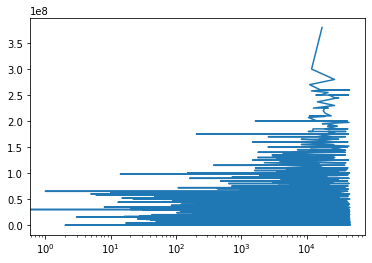

In [120]:
df.budget.sort_values().plot(logx=True,logy=False)

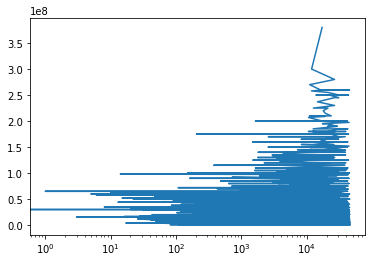

In [121]:
df.budget[df.budget > 0].sort_values().plot(logx=True,logy=False)

Budget est complet à  20.523499302000936 %


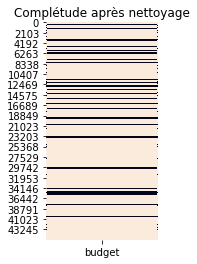

In [122]:
fig, ax = plt.subplots(figsize=(2,4))
sns.heatmap(df[['budget']]==0,cbar=False)
plt.title('Complétude après nettoyage')
print('Budget est complet à ',(1-len(df.budget[df.budget == 0])/len(df.budget))*100,'%')

#### *revenue*

De même que pour la variable *budget*, la variable *revenue* est assez mal renseignée avec une grosse proportion de films dont le revenu est renseigné comme nul. 

In [123]:
df.revenue.describe()

count    4.297700e+04
mean     1.184854e+07
std      6.610393e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.787965e+09
Name: revenue, dtype: float64

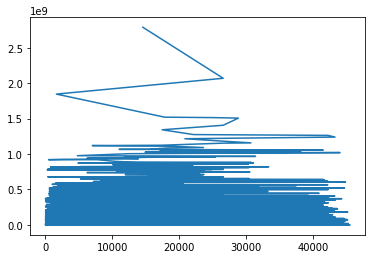

In [124]:
df.revenue.sort_values().plot()


Revenue est complet à  17.16612377850163 %


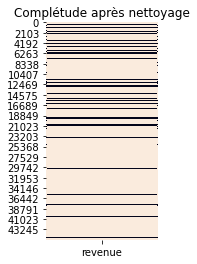

In [125]:
fig, ax = plt.subplots(figsize=(2,4))
sns.heatmap(df[['revenue']]==0,cbar=False)
plt.title('Complétude après nettoyage')
print('Revenue est complet à ',(1-len(df.revenue[df.revenue == 0])/len(df.revenue))*100,'%')

### *Original language* 


Dans notre base de données, les langues originales dans lequel le film est apparu sont codées de cette manière :

In [126]:
df.original_language[0]

'en'

En fait, il s'agit des identifiants ISO_639-1 de chaque langue (en l'occurence ici l'anglais). Pour plus de lisibilité, nous avons décidé de récupérer cette liste d'identifiants via une méthode de webscrapping, puis de créer une fonction qui renvoit la langue associée à son identifiant.

#### Scraping des identifiants ISO_639-1


La liste des codes IS0_639-1 est disponible sur l'url suivante : https://fr.wikipedia.org/wiki/Liste_des_codes_ISO_639-1.

Nous allons récupérer les identifiants, ainsi que les langues correspondantes:

In [381]:
url_iso = "https://fr.wikipedia.org/wiki/Liste_des_codes_ISO_639-1"
    
request_text = request.urlopen(url_iso).read()
page = bs4.BeautifulSoup(request_text, "lxml")

Les informations que nous désirons étant contenues dans un tableau, on le récupère puis on le convertit en Data Frame.

In [382]:
table = page.find('table')
ls = str(table)
liste_iso = pd.DataFrame(pd.read_html(ls)[0])
liste_iso

,639-1,639-2,639-3,Nom de la langue,Nom(dans la langue correspondante),Nom en anglais,Commentaire
0,aa,aar,aar,Afar,Afaraf,Afar,NaN
1,ab,abk,abk,Abkhaze,Аҧсуа,Abkhazian,NaN
2,ae,ave,ave,Avestique,Avesta,Avestan,NaN
3,af,afr,afr,Afrikaans,Afrikaans,Afrikaans,NaN
4,ak,aka,aka + 2,Akan,Akan,Akan,NaN
...,...,...,...,...,...,...,...
182,yi,yid,yid + 2,Yiddish,ייִדיש,Yiddish,NaN
183,yo,yor,yor,Yoruba,Yorùbá,Yoruba,NaN
184,za,zha,zha + 2,Zhuang,Saɯ cueŋƅ ; Saw cuengh,Zhuang,NaN
185,zh,chi/zho,zho + 13,Chinois,"中文, 汉语, 漢語",Chinese,NaN


Après une étude approfondie de la base, nous avons constaté que certains films possédaient l'identifiant 'cn' correspondant au cantonais. On le rajoute au Data Frame précédent:



In [383]:
liste_iso.loc[187] = ['cn', 'NaN', 'NaN', 'Cantonais', 'NaN', 'Cantonese', 'NaN']
liste_iso

,639-1,639-2,639-3,Nom de la langue,Nom(dans la langue correspondante),Nom en anglais,Commentaire
0,aa,aar,aar,Afar,Afaraf,Afar,NaN
1,ab,abk,abk,Abkhaze,Аҧсуа,Abkhazian,NaN
2,ae,ave,ave,Avestique,Avesta,Avestan,NaN
3,af,afr,afr,Afrikaans,Afrikaans,Afrikaans,NaN
4,ak,aka,aka + 2,Akan,Akan,Akan,NaN
...,...,...,...,...,...,...,...
183,yo,yor,yor,Yoruba,Yorùbá,Yoruba,NaN
184,za,zha,zha + 2,Zhuang,Saɯ cueŋƅ ; Saw cuengh,Zhuang,NaN
185,zh,chi/zho,zho + 13,Chinois,"中文, 汉语, 漢語",Chinese,NaN
186,zu,zul,zul,Zoulou,isiZulu,Zulu,NaN


La fonction suivante permettra de récupérer la langue associée à un identifiant ISO_639-1. En la faisant tourner, nous nous sommes rendu compte que les NaN n'étaient pas toujours indiqués de la même manière. Il faut donc prendre en compte ces cas pour éviter toute erreur lors du lancement de la fonction.

In [384]:
def find_id(id):
  if id == '' or id == 'NaN' or id == 'xx' or id == 'nan' or id =='104.0' or id =='68.0' or id =='82.0':        # on élimine le cas où la langue n'est pas indiquée
    return ''
  i = 0
  while (str((liste_iso['639-1'])[i]) == id) == False and i<len(df):
    i += 1
  return liste_iso['Nom de la langue'][i]

On teste la fonction sur la première entrée de la colonne 'original_language'

In [385]:
test = str('en')
find_id(test)

'Anglais'

Puis on généralise la méthode à toutes les cellules de cette colonne :

In [ ]:
for i in trange(len(df)):
  id = str(df.original_language[i])
  df.original_language[i] = find_id(id)

count    42800.000000
mean        95.462079
std         36.571425
min          0.000000
25%         86.000000
50%         95.000000
75%        107.000000
max       1256.000000
Name: runtime, dtype: float64

In [ ]:
df.to_csv('base.csv')

# Scraping de mots-clés caractérisant le film
Le but de cette partie est de récupérer des mots-clés pour chaque film de la base. Pour un film donné, d'identifiant imbd_id, nous allons scraper la page https://www.imdb.com/title/imbd_id/keywords. Tout l'intérêt de la démarche est de pouvoir ensuite réaliser des nuages de mots, pour tenter de mettre en évidence les thématiques qui plaisent au public

In [59]:
url_keywords = "https://www.imdb.com/title/" + df.imdb_id[1] +"/keywords"
    
request_text = request.urlopen(url_keywords).read()
page = bs4.BeautifulSoup(request_text, "lxml")

On peut ensuite récupérer facilement les mots-clés, repérés dans le code source par 'data-item-keyword' :

In [ ]:
for post in page.findAll('td'):
    print(post.get('data-item-keyword'))

On généralise la démarche à tous les films de la base, puis on stocke les mots-clés dans une nouvelle variable. Cependant, il a fallu exclure certains indices car nous avons constaté que pour ceux-ci, le lien https://www.imdb.com/title/imbd_id/keywords n'existait pas.

In [ ]:
df_new_column = pd.DataFrame(0, index=np.arange(len(df)), columns=['keywords'])
df_2 = pd.concat([df.imdb_id, df.title, df_new_column], axis=1)

df_2

Code de scrapping des mots clefs. Malheureusement ce code étant très chronophage, on se contentera de charger les mots-clefs déjà scrappés.


```
for i in trange(len(df)):
  if df.imdb_id[i] == None or str(df.imdb_id[i]) == 'nan' or str(df.imdb_id[i]) == 'NaN' or str(df.imdb_id[i]) == '0' or i == 30399 or i == 30544 or i==33357:
    pass
  else:
    url_keywords = "https://www.imdb.com/title/" + df.imdb_id[i] +"/keywords"
    request_text = request.urlopen(url_keywords).read()
    page = bs4.BeautifulSoup(request_text, "lxml")
    l = []
    for post in page.findAll('td'):
      l.append(post.get('data-item-keyword'))
    df_2.keywords[i] = l
    
df_2.to_csv('base_keywords.csv', sep = ';', encoding ='utf-8') 
```



Voici ce que donne ce code sur les 10 premières lignes de la base :

In [ ]:
for i in trange(10):
  if df.imdb_id[i] == None or str(df.imdb_id[i]) == 'nan' or str(df.imdb_id[i]) == 'NaN' or str(df.imdb_id[i]) == '0' or i == 30399 or i == 30544 or i==33357:
    pass
  else:
    url_keywords = "https://www.imdb.com/title/" + df.imdb_id[i] +"/keywords"
    request_text = request.urlopen(url_keywords).read()
    page = bs4.BeautifulSoup(request_text, "lxml")
    l = []
    for post in page.findAll('td'):
      l.append(post.get('data-item-keyword'))
    df_2.keywords[i] = l


# Scraping des notes sur IMDB

Pour enrichir notre analyse, nous avons voulu obtenir les notes données aux films sur un autre site, IMDB. Pour cela, nous allons scraper les pages sources des films présentant un imdb_id, à l'adresse https://www.imdb.com/title/imbd_id/keywords

In [127]:
url_rate = "https://www.imdb.com/title/" + df.imdb_id[0]
    
request_text = request.urlopen(url_rate).read()
page = bs4.BeautifulSoup(request_text, "lxml")

Dans ce code source, on récupère la note moyenne, renseignée par 'ratingValue':

In [128]:
p = page.find_all('span',{ 'itemprop' : 'ratingValue'})
p[0].contents[0]

'8.3'

On généralise le processus à toute la base et on crée une nouvelle variable imdb_rate dans laquelle on stocke ces informations.

In [129]:
df_new_column = pd.DataFrame(0, index=df.index, columns=['imdb_rate'])
#df2 = pd.concat([df, df_new_column], axis=1)
df = df.join(df_new_column, how='inner')

In [130]:
for i in trange(len(df)):
  if df.imdb_id[i] == None or str(df.imdb_id[i]) == 'nan' or str(df.imdb_id[i]) == 'NaN' or str(df.imdb_id[i]) == '0' or i == 30399 or i == 30544 or i==33357:
    pass
  else:
    url_rate = "https://www.imdb.com/title/" + df.imdb_id[i]
    request_text = request.urlopen(url_rate).read()
    page = bs4.BeautifulSoup(request_text, "lxml")
    p = page.find_all('span',{ 'itemprop' : 'ratingValue'})
    df.imdb_rate[i] = p[0].contents[0]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



KeyboardInterrupt: ignored

In [70]:
df

,budget,genres,imdb_id,original_language,original_title,overview,popularity,release_date,revenue,runtime,status,title,vote_average,vote_count,collection,score_1,production_companies_name,production_companies_id,country_code,country_name,imdb_rate
id,,,,,,,,,,,,,,,,,,,,,
862,30000000.0,"Animation, Comedy, Family",tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,81.0,Released,Toy Story,7.7,5415.0,1,41695.5,Pixar Animation Studios,3,US,United States of America,0
8844,65000000.0,"Adventure, Fantasy, Family",tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,1995-12-15,262797249.0,104.0,Released,Jumanji,6.9,2413.0,0,16649.7,TriStar Pictures,559,US,United States of America,0
15602,0.0,"Romance, Comedy",tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,1995-12-22,0.0,101.0,Released,Grumpier Old Men,6.5,92.0,1,598.0,Warner Bros,6194,US,United States of America,0
31357,16000000.0,"Comedy, Drama, Romance",tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,1995-12-22,81452156.0,127.0,Released,Waiting to Exhale,6.1,34.0,0,207.4,Twentieth Century Fox Film Corporation,306,US,United States of America,0
11862,0.0,Comedy,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,1995-02-10,76578911.0,106.0,Released,Father of the Bride Part II,5.7,173.0,1,986.1,Sandollar Productions,5842,US,United States of America,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222848,0.0,id 878 name Science Fiction,tt0112613,en,Caged Heat 3000,It's the year 3000 AD. The world's most danger...,0.661558,1995-01-01,0.0,85.0,Released,Caged Heat 3000,3.5,1.0,0,3.5,ConcordeNew Horizons,4688,US,United States of America,0
30840,0.0,id name Drama id name Action id 10749 name R...,tt0102797,en,Robin Hood,"Yet another version of the classic epic, with ...",5.683753,1991-05-13,0.0,104.0,Released,Robin Hood,5.7,26.0,0,148.2,Westdeutscher Rundfunk WDR,7025,CA,Canada,0
439050,0.0,id name Drama id name Family,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,NaN,0.0,90.0,Released,Subdue,4.0,1.0,0,4.0,NaN,NaN,IR,Iran,0
